In [1]:
import torch
import numpy as np
import cv2

import matplotlib.pyplot as plt
import pickle as pkl

import os
import random
import shutil

from PIL import Image
from torchvision.datasets import MNIST

In [2]:
#!pip install opencv-python

In [3]:
plt.rcParams['image.cmap'] = 'Blues_r'

## Preprocess MNIST

Save MNIST to disk split by digit value.

In [4]:
MNIST_data = MNIST(root='./data', train=True, download=True, transform=None)

1.5%

31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

71.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


102.8%
3.3%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



70.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
# create directory to save separated data
if not os.path.exists('./data/MNIST_sep'):
    os.makedirs('./data/MNIST_sep')
    
# save each image in labeled directory
num_per_class = [0 for _ in range(10)]
for image, y in MNIST_data:
    save_dir = f'./data/MNIST_sep/{y}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    x = np.asarray(image) / 256
    with open(f'{save_dir}/{num_per_class[y]}.pkl', 'wb+') as f:
        pkl.dump(x, f)    
    num_per_class[y] += 1

with open(f'./data/MNIST_sep/num_per_class.pkl', 'wb+') as f:
    pkl.dump(num_per_class, f)

In [6]:
# delete separated data
# import shutil
# shutil.rmtree('./data/MNIST_sep')

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


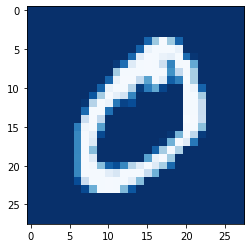

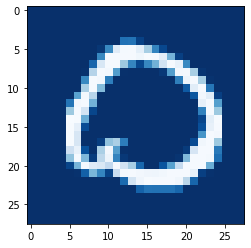

In [7]:
# show saved data is correct
with open('./data/MNIST_sep/0/0.pkl', 'rb') as f:
    x1 = pkl.load(f)
with open('./data/MNIST_sep/0/100.pkl', 'rb') as f:
    x2 = pkl.load(f)
    
with open('./data/MNIST_sep/num_per_class.pkl', 'rb') as f:
    npc = pkl.load(f)
    
print(npc)
plt.imshow(x1)
plt.show()
plt.imshow(x2)
plt.show()

## Save to YOLO Format

In [8]:
num_samples = 10000
YOLO_data_dir = './data/YOLO_data_dg'
MAX_DIGITS = 5

with open('./data/MNIST_sep/num_per_class.pkl', 'rb') as f:
    num_per_class = pkl.load(f)
    
# create directory to save YOLO data
if not os.path.exists(YOLO_data_dir):
    os.makedirs(YOLO_data_dir)
if not os.path.exists(f'{YOLO_data_dir}/images'):
    os.makedirs(f'{YOLO_data_dir}/images')
if not os.path.exists(f'{YOLO_data_dir}/labels'):
    os.makedirs(f'{YOLO_data_dir}/labels')

In [9]:
def save_YOLO_format(image, annotations, save_name):
    """
    image: image
    annotations: array of bboxes [(class, x_coord, y_coord, width, height), ...]
        - normalized to scale of image (coords and lengths in [0, 1])
        - values in bboxes must be strings
    save_name: image and annotations will be saved as f'{save_name}.png' and f'{save_name}_annotations.txt'
    """
    
    image.save(f'{YOLO_data_dir}/images/{save_name}.png', 'png')
    
    with open(f'{YOLO_data_dir}/labels/{save_name}.txt', 'w+') as f:
        for annotation in annotations:
            f.write(' '.join(annotation) + '\n')

In [10]:
def create_YOLO_sample(sample):
    """
    sample: string of digits to create the sample
        - ex. 194
    returns numpy image and list of annotations
    """
    images = []
    annotations = []
    for idx, digit in enumerate(sample):
        if digit == '_':
            images.append(np.zeros((28, 28)))
            continue
        
        image_to_stitch_idx = random.randint(0, num_per_class[int(digit)] - 1)
        with open(f'./data/MNIST_sep/{digit}/{image_to_stitch_idx}.pkl', 'rb') as f:
            image_to_stitch = pkl.load(f)
        images.append(image_to_stitch)
        
        digit_class = digit
        x_coord = str((idx + 0.5) / len(sample))
        y_coord = str(0.5)
        width = str(0.9 / len(sample))
        height = str(0.9)
        
        annotations.append((digit_class, x_coord, y_coord, width, height))
    
    image_np = np.concatenate(images, axis=1)
    image = Image.fromarray(256 * image_np).convert('L')
    
    return image, annotations

In [11]:
# generate and save YOLO data and annotations
for sample_num in range(num_samples):
    sample = str(random.randint(1, int('9' * MAX_DIGITS)))
    
    # insert blanks randomly to front and back of sample to get same size samples
    while len(sample) < MAX_DIGITS:
        # use '_' to denote a blank
        sample = '_' + sample if random.uniform(0, 1) < 0.5 else sample + '_'
    
    image, annotations = create_YOLO_sample(sample)
    save_YOLO_format(image, annotations, str(sample_num))

In [12]:
# delete YOLO data
# shutil.rmtree(YOLO_data_dir)
# shutil.rmtree(f'{YOLO_data_dir}/images')
# shutil.rmtree(f'{YOLO_data_dir}/labels')

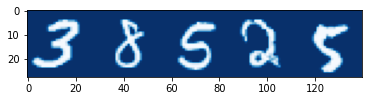

3 0.1 0.5 0.18 0.9
8 0.3 0.5 0.18 0.9
5 0.5 0.5 0.18 0.9
2 0.7 0.5 0.18 0.9
5 0.9 0.5 0.18 0.9



In [13]:
# show it worked
image = Image.open(f'{YOLO_data_dir}/images/705.png')
plt.imshow(image)
plt.show()

with open(f'{YOLO_data_dir}/labels/705.txt', 'r') as f:
    ann_sample = f.read()
    print(ann_sample)

## Visualize using bounding box

In [14]:
def convert_from_yolo_to_cv2(input_txt):
    
    updated=[]
    annotations = input_txt.split('\n')[:-1]
    
    for i in annotations:
        temp = i.split(' ')
        temp[1] = round(float(temp[1])*(28*MAX_DIGITS))
        temp[2] = round(float(temp[2])*(28))
        temp[3] = round(float(temp[3])*(28*MAX_DIGITS))
        temp[4] = round(float(temp[4])*(28))

        # x min
        x_min = int(temp[1]-temp[3]/2)
        x_max = int(temp[1]+temp[3]/2)
        y_min = int(temp[2]-temp[4]/2)
        y_max = int(temp[2]+temp[4]/2)

        updated.append([temp[0], x_min,x_max,y_min,y_max])
    
    return updated

In [15]:
image

In [16]:
image2 = np.array(image)
for i in convert_from_yolo_to_cv2(ann_sample):
    image2=cv2.rectangle(np.array(image2), pt1=(i[1],i[4]), pt2=(i[2],i[3]),
                                  color=(255,255,255), thickness=1)
    print((i[1],i[4]))
    print((i[2],i[3]))
    

(1, 26)
(26, 1)
(29, 26)
(54, 1)
(57, 26)
(82, 1)
(85, 26)
(110, 1)
(113, 26)
(138, 1)


In [17]:
print(ann_sample)

3 0.1 0.5 0.18 0.9
8 0.3 0.5 0.18 0.9
5 0.5 0.5 0.18 0.9
2 0.7 0.5 0.18 0.9
5 0.9 0.5 0.18 0.9



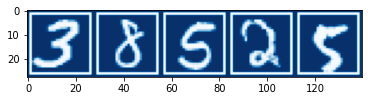

In [18]:
#plt.figsize()
plt.imshow(image2)
plt.show()

## Randomly select 1000 to put in validation

In [19]:
images_list = sorted(os.listdir('data/YOLO_data_dg/images/'))
labels_list = sorted(os.listdir('data/YOLO_data_dg/labels/'))

In [20]:
print(len(images_list))
print(len(labels_list))
print(images_list[0:5])
print(labels_list[0:5])

10000
10000
['0.png', '1.png', '10.png', '100.png', '1000.png']
['0.txt', '1.txt', '10.txt', '100.txt', '1000.txt']


In [21]:
nums = list(range(0, len(images_list)))
random.shuffle(nums)
valid_idx = nums[:1000]
train_idx = nums[1000:]

In [22]:
print(len(valid_idx))
print(len(set(valid_idx)))
print(len(train_idx))
print(len(set(train_idx)))
print(valid_idx[0:5])

1000
1000
9000
9000
[1314, 7725, 9569, 2969, 1497]


In [23]:
train_img_dir = os.path.join(YOLO_data_dir, 'train/images/')
train_lab_dir = os.path.join(YOLO_data_dir, 'train/labels/')

valid_img_dir = os.path.join(YOLO_data_dir, 'valid/images/')
valid_lab_dir = os.path.join(YOLO_data_dir, 'valid/labels/')

for p in [train_img_dir, train_lab_dir, valid_img_dir, valid_lab_dir]:
    if not os.path.exists(p):
        os.makedirs(p)

In [24]:
# # delete directories
# shutil.rmtree(train_img_dir)
# shutil.rmtree(train_lab_dir)
# shutil.rmtree(valid_img_dir)
# shutil.rmtree(valid_lab_dir)

In [25]:
for idx_v in valid_idx:
    shutil.copy(os.path.join(YOLO_data_dir+'/images', images_list[idx_v]), os.path.join(valid_img_dir , images_list[idx_v]))
    shutil.copy(os.path.join(YOLO_data_dir+'/labels', labels_list[idx_v]), os.path.join(valid_lab_dir , labels_list[idx_v]))
    
for idx_t in train_idx:
    shutil.copy(os.path.join(YOLO_data_dir+'/images', images_list[idx_t]), os.path.join(train_img_dir , images_list[idx_t]))
    shutil.copy(os.path.join(YOLO_data_dir+'/labels', labels_list[idx_t]), os.path.join(train_lab_dir , labels_list[idx_t]))


In [26]:
set.intersection(set(train_idx), set(valid_idx))

set()